In [38]:
#Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import api as sm

#Necessary Methods
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

# Model Imports
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars,LassoLars,OrthogonalMatchingPursuit,BayesianRidge,SGDRegressor,PassiveAggressiveRegressor
from sklearn.svm import SVR,NuSVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from pingouin import kruskal

df = pd.read_csv("/Users/nishi/Downloads/archive/train.csv")
test = pd.read_csv("/Users/nishi/Downloads/archive/test.csv")

train.head()
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   int64  
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   int64  
 9   Outlet_Location_Type       8523 non-null   int64  
 10  Outlet_Type                8523 non-null   int64  
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(5), object(3)
memory usage: 799.2+ KB


,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,780.170949,140.992782,1997.831867,1.342016,1.046580,0.692127,2181.288914
std,4.643456,0.051598,341.615588,62.275067,8.371760,1.200408,0.777719,1.060931,1706.499616
min,4.555000,0.000000,64.000000,31.290000,1985.000000,0.000000,0.000000,0.000000,33.290000
25%,8.773750,0.026989,520.000000,93.826500,1987.000000,0.000000,0.000000,0.000000,834.247400
50%,12.600000,0.053931,682.000000,143.012800,1999.000000,1.000000,1.000000,0.000000,1794.331000
75%,16.850000,0.094585,1200.000000,185.643700,2004.000000,3.000000,2.000000,1.000000,3101.296400
max,21.350000,0.328391,1232.000000,266.888400,2009.000000,3.000000,2.000000,3.000000,13086.964800


Exploratory Data Analysis : get some insight and find any irregularities


In [6]:
#check for duplicates
idstotal = train.shape[0]
idsdupli = train[train['Item_Identifier'].duplicated()]

print(f'There are {len(idsdupli)} duplicate IDs for {idstotal} total entries')

There are 6964 duplicate IDs for 8523 total entries


Univariate Analysis

Text(0.5, 1.0, 'Item_Outlet_Sales Distribution')

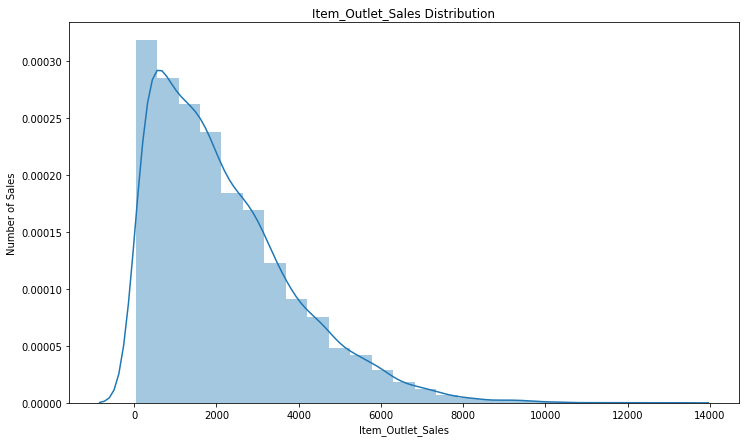

In [7]:
plt.figure(figsize=(12,7))
sns.distplot(train.Item_Outlet_Sales, bins = 25)
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Number of Sales")
plt.title("Item_Outlet_Sales Distribution")


In [8]:
print ("Skew is:", train.Item_Outlet_Sales.skew())
print("Kurtosis: %f" % train.Item_Outlet_Sales.kurt())

Skew is: 1.1775306028542798
Kurtosis: 1.615877


Numerical preditors : consider all of the dependent variables

In [9]:
num_features = train.select_dtypes(include=[np.number])
num_features.dtypes

Item_Weight                  float64
Item_Visibility              float64
Item_MRP                     float64
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
dtype: object

In [10]:
#check the correlation between our dependent variables and target variable
corr = num_features.corr()
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


In [11]:
corr['Item_Outlet_Sales'].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.014123
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.128625
Name: Item_Outlet_Sales, dtype: float64

Categorical Variables

In [17]:
# Handling categorical feature
df_cat=train[['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type']]
df_cat.head()
# Checking the length of unique values in feature
for feature in df_cat:
    print(feature,':',len(df_cat[feature].unique()))

Item_Fat_Content : 5
Item_Type : 16
Outlet_Size : 4
Outlet_Location_Type : 3
Outlet_Type : 4


In [19]:
train.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [20]:
df_1={i:k for k,i in enumerate(train.Outlet_Size.unique())}
df_1

{'Medium': 0, nan: 1, 'High': 2, 'Small': 3}

In [21]:
train['Outlet_Size']=train['Outlet_Size'].map(df_1)

In [22]:
df_2={i:k for k,i in enumerate(train.Outlet_Location_Type.unique())}
df_2

{'Tier 1': 0, 'Tier 3': 1, 'Tier 2': 2}

In [23]:
train['Outlet_Location_Type']=train['Outlet_Location_Type'].map(df_2)
train.Outlet_Type.unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [24]:
df_3={i:k for k,i in enumerate(train.Outlet_Type.unique())}
df_3

{'Supermarket Type1': 0,
 'Supermarket Type2': 1,
 'Grocery Store': 2,
 'Supermarket Type3': 3}

In [25]:
train.Outlet_Type=train.Outlet_Type.map(df_3)
df_4=train.Item_Type.value_counts().to_dict()
train['Item_Type']=train['Item_Type'].map(df_4)

In [27]:
X=train.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'],axis=1)
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,Low Fat,0.016047,682,249.8092,1999,0,0,0
1,5.92,Regular,0.019278,445,48.2692,2009,0,1,1
2,17.50,Low Fat,0.016760,425,141.6180,1999,0,0,0
3,19.20,Regular,0.000000,1232,182.0950,1998,1,1,2
4,8.93,Low Fat,0.000000,910,53.8614,1987,2,1,0


In [29]:
y=pd.DataFrame(train.iloc[:,-1])
y.head()

,Item_Outlet_Sales
0,3735.1380
1,443.4228
2,2097.2700
3,732.3800
4,994.7052


In [39]:
gb=df.groupby('Outlet_Identifier')
for i in ['Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type']:
  print(f"{i} : {gb[i].unique()}")

df.drop(columns=['Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Identifier'],inplace=True)
df=df.groupby('Item_Type',group_keys=False).apply(lambda x:x.fillna(x.mean()))
df


Outlet_Establishment_Year : Outlet_Identifier
OUT010    [1998]
OUT013    [1987]
OUT017    [2007]
OUT018    [2009]
OUT019    [1985]
OUT027    [1985]
OUT035    [2004]
OUT045    [2002]
OUT046    [1997]
OUT049    [1999]
Name: Outlet_Establishment_Year, dtype: object
Outlet_Size : Outlet_Identifier
OUT010       [nan]
OUT013      [High]
OUT017       [nan]
OUT018    [Medium]
OUT019     [Small]
OUT027    [Medium]
OUT035     [Small]
OUT045       [nan]
OUT046     [Small]
OUT049    [Medium]
Name: Outlet_Size, dtype: object
Outlet_Location_Type : Outlet_Identifier
OUT010    [Tier 3]
OUT013    [Tier 3]
OUT017    [Tier 2]
OUT018    [Tier 3]
OUT019    [Tier 1]
OUT027    [Tier 3]
OUT035    [Tier 2]
OUT045    [Tier 2]
OUT046    [Tier 1]
OUT049    [Tier 1]
Name: Outlet_Location_Type, dtype: object
Outlet_Type : Outlet_Identifier
OUT010        [Grocery Store]
OUT013    [Supermarket Type1]
OUT017    [Supermarket Type1]
OUT018    [Supermarket Type2]
OUT019        [Grocery Store]
OUT027    [Supermarket Type

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Item_Outlet_Sales
5,10.395000,Regular,0.000000,Baking Goods,51.4008,OUT018,556.6088
21,12.277108,Regular,0.035400,Baking Goods,144.5444,OUT027,4064.0432
23,12.277108,Low Fat,0.057557,Baking Goods,107.6938,OUT019,214.3876
48,15.850000,Regular,0.121633,Baking Goods,60.6220,OUT046,2576.6460
71,15.850000,Regular,0.121532,Baking Goods,59.2220,OUT013,599.2200
...,...,...,...,...,...,...,...
8360,11.500000,Low Fat,0.014884,Starchy Foods,174.5080,OUT049,3635.2680
8397,16.700000,Regular,0.054851,Starchy Foods,64.4168,OUT018,830.9184
8411,7.600000,Regular,0.142632,Starchy Foods,172.3448,OUT049,4431.5648
8426,7.435000,Low Fat,0.084436,Starchy Foods,168.6158,OUT035,4512.1266
